In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import quad
from matplotlib import rc
from matplotlib.colors import LogNorm
from scipy import interpolate

plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif')

# constants
pi = 3.14159265359
alpha = 1 / 137.035999084  # fine structure constant
me = 510998.950  # e- mass [eV]
Mpl = 2e27  # planck mass [eV]
zeta3 = 1.202056903159594  # Riemann zeta(3)
amu = 931.494e6  # amu in eV

# conversion factors
s2eV = 6.582119569e-16  # Hz to eV
J2eV = 1.0 / 1.602176634e-19  # Joules to eV (1 / e)
m2eV = 1.973269804e-7  # m-1 to eV
K2eV = 8.617333262e-5  # Kelvin to eV
kg2eV = 5.609588604e35
T2eV = 2e2 # Tesla to eV2 conversion [eV2/T]
G2eV = 2e-2 # Gauss to eV2 conversion [eV2/G]

# file = "/home/yuangw/Documents/GitHub/Chameleons/2406.01691/data/"
file = "/Users/yuangw/Documents/GitHub/chameleons/2406.01691/data/"
r = np.loadtxt(file + "r.dat")  # radial distance [eV-1]
T = np.loadtxt(file + "T.dat")  # solar temperature [eV]
rho = np.loadtxt(file + "rho.dat")  # solar density [eV4]
ne = np.loadtxt(file + "ne.dat")  # electron number density [eV3]
nbar = np.loadtxt(file + "nbar.dat")  # Z2-summed number density [eV3]
nbar2 = np.loadtxt(file + "nbar2.dat")  # Z2-summed number density minus electrons [eV3]
wp = np.loadtxt(file + "wp.dat")  # plasma frequency [eV]
nH = np.loadtxt(file + "nH.dat")  # H number density [eV3]
nHe3 = np.loadtxt(file + "nHe3.dat")  # He3 number density [eV3]
nHe4 = np.loadtxt(file + "nHe4.dat")  # He4 number density [eV3]
z1 = np.loadtxt(file + "Z1.dat")  # gaunt factors for Z=1
z2 = np.loadtxt(file + "Z2.dat")  # gaunt factors for Z=2

# Define the interpolation functions for the solar model data vs. radius in [eV]
rho_r = interpolate.interp1d(r, rho, fill_value=(0.0, 0.0), bounds_error=False)
T_r = interpolate.interp1d(r, T, fill_value=(0.0, 0.0), bounds_error=False)
ne_r = interpolate.interp1d(r, ne, fill_value=(0.0, 0.0), bounds_error=False)
wp_r = interpolate.interp1d(r, wp, fill_value=(0.0, 0.0), bounds_error=False)
nbar_r = interpolate.interp1d(r, nbar, fill_value=(0.0, 0.0), bounds_error=False)
nbar2_r = interpolate.interp1d(r, nbar2, fill_value=(0.0, 0.0), bounds_error=False)
nH_r = interpolate.interp1d(r, nH, fill_value=(0.0, 0.0), bounds_error=False)
nHe3_r = interpolate.interp1d(r, nHe3, fill_value=(0.0, 0.0), bounds_error=False)
nHe4_r = interpolate.interp1d(r, nHe4, fill_value=(0.0, 0.0), bounds_error=False)

/var/folders/jg/fgqgnyxs1tlcbr5x6bxs_gl40000gn/T/ipykernel_41974/1369678273.py:100: RuntimeWarning: overflow encountered in exp
  factor2 = (np.power( (mg2 - ms2), 2.0) + (w*w*G*G) ) * (np.exp(w/Tr) - 1.0)
/var/folders/jg/fgqgnyxs1tlcbr5x6bxs_gl40000gn/T/ipykernel_41974/1369678273.py:158: RuntimeWarning: overflow encountered in exp
  bose = nbarr / (np.exp(w / Tr) - 1)


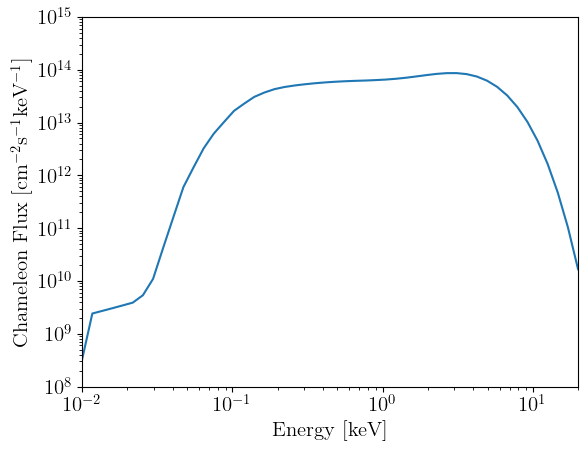

In [65]:
Dist = 1.496e13  ## cm, average distance between Earth and Sun
gg = 10.0  ## beta_gamma, chameleon coupling with photon
ge = 2.0   ## beta_matter, chameleon coupling with matter/electron

def mCham2(r, Bm=100.0, E=2.4e-3, n=1.0):  # effective mass square, Eq.18 in 2406.01691
    """Chameleon mass squared as a function of solar radius."""
    E4n = E**(4 + n)
    x = Bm * rho_r(r) / (n * Mpl * E4n)
    x = np.clip(x, 1e-30, None) # set minimum value, avoid log(0) or negative value  
    return n * (n + 1) * E4n * np.power(x, (n + 2) / (n + 1))  #eV2

############################# Bulk Magnetic Field #############################
Bf1 = [3000.0*T2eV, 50.0*T2eV, 4.0*T2eV]  # [eV2]
Bf2 = [200.0*T2eV,  4.0*T2eV,  3.0*T2eV]

rSolar = 6.957e8 / m2eV  # solar radius [eV-1]
radius = rSolar * np.logspace(-2, 0, 300)  # [eV-1]
Rrad = 0.712   
Rtach = 0.732   
Rupper = 0.96   
dtach = 0.02   
dupper = 0.035  

def Bsolar(rr, B):
    r = rr / rSolar  # radius dimensionless
    if r < Rrad:  # radiative zone
        lam = 10 * Rrad +1
        x = r / Rrad
        return B[0] * (1 + lam) * np.power(1 + 1 / lam, lam) * x**2 * np.power(1 - x**2, lam)
    
    elif Rtach - dtach < r < Rtach + dtach: # tachocline
        return B[1] * (1 - ((r - Rtach) / dtach)**2.0)

    elif Rupper - dupper < r < Rupper + dupper: # outer region
        return B[2] * (1 - ((r - Rupper) / dupper)**2.0)

    else:
        return 0.0
   
Bsolar_vec1 = np.vectorize(lambda r: Bsolar(r, Bf1))
Bsolar_vec2 = np.vectorize(lambda r: Bsolar(r, Bf2))

def GammaPhoton(r, w, g1, g2):  # absorption-production, paper 2406.01691 Eq.A20
    Tr = np.clip(T_r(r), 1e-5, None)  # avoid division by zero or negative values
    ner = np.clip(ne_r(r), 1e-5, None)
    nHr = np.clip(nH_r(r), 1e-5, None)
    nHe3r = np.clip(nHe3_r(r), 1e-5, None)
    nHe4r = np.clip(nHe4_r(r), 1e-5, None)
    
    p1 = 64 * pi**2 * np.power(alpha, 3)
    p2 = 3 * np.power(me, 2) * np.power(w, 3)
    p3 = me * np.power(ner, 2) / (2 * pi * Tr)
    p4 = 1 - np.exp(-w / Tr)
    p5 = 8 * pi * np.power(alpha, 2) * ner / (3 * np.power(me, 2))
    ions = (nHr * g1) + g2 * (4 * nHe4r + 4 * nHe3r)  # sum of ion densities
    return p1/p2 * np.sqrt(p3) * p4 * ions + p5


####Find the nearest two temperatures T1, T2 in the table that bracket the actual physical temperature T_r(r) at that radius.
####But the table gives Θ = T / mₑ, so to compare with a physical T, you must divide by me when searching
def selectG(r, w):
    """Selects Gaunt factor from matrix and computes Gamma (eV)."""
    a1 = a2 = b1 = b2 = 1
    Tr = np.clip(T_r(r), 1e-10, None)  # avoid division by zero

    # convert Gaunt factor Theta to T in eV, Find indices for temperature interpolation
    xx1 = np.append(0, z1[0])
    xx2 = np.append(0, z2[0])
    for i in range(1, 200):
        if xx1[i] < Tr/me < xx1[i + 1]:
            a1 = i
        if xx2[i] < Tr/me < xx2[i + 1]:
            a2 = i

    # Find indices for frequency interpolation
    for i in range(1, 500):
        if (z1[i][0] * Tr) < w < (z1[i + 1][0] * Tr):
            b1 = i
        if (z2[i][0] * Tr) < w < (z2[i + 1][0] * Tr):
            b2 = i

    g1 = z1[b1][a1]
    g2 = z2[b2][a2]
    return GammaPhoton(r, w, g1, g2)


def B_integrand1(r, w, Bm, E, n):  # [eV Bg-2] Eq.7 in paper 2406.01691
    """Differential scalar production rate due to magnetic field."""
    Tr = np.clip(T_r(r), 1e-5, None)  # avoid division by zero
    ner = np.clip(ne_r(r), 1e-10, None)
    
    mg2 = 4 * pi * alpha * ner / me
    ms2 = mCham2(r, Bm, E, n)
    if w**2 <= mg2 or w**2 <= ms2 or mg2 == ms2:
        return 0.0
    
    B = Bsolar_vec1(r)
    G = selectG(r, w)
    factor1 = w* np.power(w*w - ms2, 1.5) * G
    factor2 = (np.power( (mg2 - ms2), 2.0) + (w*w*G*G) ) * (np.exp(w/Tr) - 1.0)
    kernel = 2 * r**2.0 * B**2.0/(pi*Mpl*Mpl)  * factor1/(factor2)
    return kernel * 1e3/s2eV  # factor 1e3/s2eV convert [eV/eV] to [s-1 keV-1]

B_integrand_vec1 = np.vectorize(B_integrand1)

def B_solarIntg1(w, Bm, E, n):
    return np.trapz(B_integrand_vec1(radius, w, Bm, E, n), radius)  # integrate over radius

def B_integrand2(r, w, Bm, E, n):  # [eV Bg-2] Eq.7 in paper 2406.01691
    """Differential scalar production rate due to magnetic field."""
    Tr = np.clip(T_r(r), 1e-5, None)  # avoid division by zero
    ner = np.clip(ne_r(r), 1e-10, None)
    
    mg2 = 4 * pi * alpha * ner / me
    ms2 = mCham2(r, Bm, E, n)
    if w**2 <= mg2 or w**2 <= ms2 or mg2 == ms2:
        return 0.0
    
    B = Bsolar_vec2(r)
    G = selectG(r, w)
    factor1 = w* np.power(w*w - ms2, 1.5) * G
    factor2 = (np.power( (mg2 - ms2), 2.0) + (w*w*G*G) ) * (np.exp(w/Tr) - 1.0)
    kernel = 2 * r**2.0 * B**2.0/(pi*Mpl*Mpl)  * factor1/(factor2)
    return kernel * 1e3/s2eV  # factor 1e3/s2eV convert [eV/eV] to [s-1 keV-1]

B_integrand_vec2 = np.vectorize(B_integrand2)

def B_solarIntg2(w, Bm, E, n):
    return np.trapz(B_integrand_vec2(radius, w, Bm, E, n), radius)  # integrate over radius

############################# Primakoff Process #############################
# Define curlyI
def curlyI(u, v):
    return (u*u - 1) / v * np.log((u - 1) / (u + 1)) - ((u + v)**2 - 1) / v * np.log((u + v - 1) / (u + v + 1)) - 2

def curlyIapprox(u, v):   # Define curlyI approximation near u => 1
    return u*u / v - (v + 2) * np.log(v / (v + 2)) - 2

def T_integrand(r, w, Bm, E, n):
    """Differential scalar production rate on Earth d2N/dw divided by beta_gamma^2"""
    Tr = np.clip(T_r(r), 1, None)  # avoid division by zero
    ner = np.clip(ne_r(r), 1e-5, None)
    nbarr = np.clip(nbar_r(r), 1e-5, None)

    mg2 = 4 * pi * alpha * ner / me
    ms2 = mCham2(r, Bm, E, n)
    if w**2 <= mg2 or w**2 <= ms2:
        return 0.0

    K2 = 8 * pi * alpha * nbarr / Tr
    kgamma = np.sqrt(np.abs(w**2 - mg2))
    kphi = np.sqrt(np.abs(w**2 - ms2))
    uArg = kgamma / (2 * kphi) + kphi / (2 * kgamma)
    vArg = K2 / (2 * kphi * kgamma)

    Iuv = curlyI(uArg, vArg) if uArg >= 1.01 else curlyIapprox(uArg, vArg)
    factor = alpha/ (8 * Mpl**2 * pi)
    bose = nbarr / (np.exp(w / Tr) - 1)
    
    kernel = factor * r**2 * bose * w**2 * kphi/ kgamma * Iuv
    return kernel *1e3/s2eV  # factor 1e3/s2eV convert [eV/eV] to [s-1 keV-1]

T_integrand_vec = np.vectorize(T_integrand)

def T_solarIntg(w, Bm, E, n):
    return np.trapz(T_integrand_vec(radius, w, Bm, E, n), radius)  # integrate over radius

def flux_earth(w, Bm, E, n, gg=10.0):
    "the differential chameleon flux at Earth in cm^-2 s^-1 keV^-1"
    bulk = B_solarIntg1(w, Bm, E, n)
    primakoff = T_solarIntg(w, Bm, E, n)
    return 100.0**gg *(bulk + primakoff)/(4*pi*Dist*Dist)


flux_earth = np.vectorize(flux_earth)
w_array = np.logspace(1, 4.3, 50)  # [eV]
flux = np.array([flux_earth(wi, Bm=100.0, E=1.0e-3, n=1.0, gg=10.0) for wi in w_array])

plt.plot(w_array/1e3, flux)
plt.xlabel(r'${\rm Energy~[keV]}$', fontsize=15)
plt.ylabel(r'${\rm Chameleon~Flux~[cm^{-2}s^{-1} keV^{-1}}]$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0.01, 20)
plt.ylim(1e8, 1e15)
plt.xscale('log')
plt.yscale('log')
plt.show()

/var/folders/jg/fgqgnyxs1tlcbr5x6bxs_gl40000gn/T/ipykernel_41974/1369678273.py:100: RuntimeWarning: overflow encountered in exp
  factor2 = (np.power( (mg2 - ms2), 2.0) + (w*w*G*G) ) * (np.exp(w/Tr) - 1.0)


Gaussian/skew_Gaussian =  848.5571256581699 827.41483498834


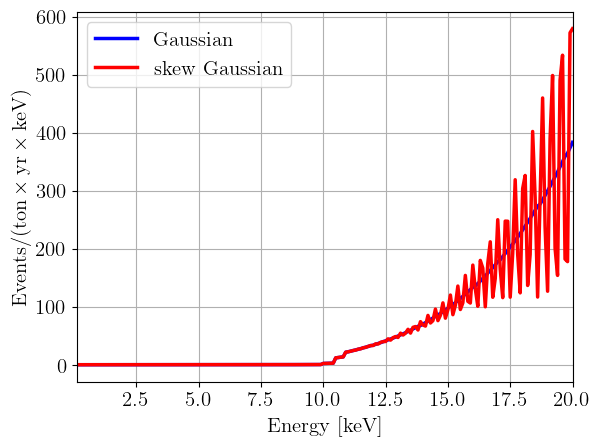

In [ ]:
NXe   = 4.58644e21   # Number of Xe atoms per g
tXE   = 1.042e6      # XENON1T target in g
year  = 3.15e7       # conversion from year to s
conv  = 10**6*year   # conversion from (g*s)^-1 to (year*ton)^-1
eX1T = 0.65 # XENON1T exposure for 1042kg Xe for 226.9days
eXnT = 20   # Projected exposure for XENONnT

hbar  = 6.582119569e-19 # Planck's constant  [keV s]
cs    = 2.99792458e10   # speed of light     [cm/s]
hbarc = hbar*cs         #                    [keV*cm]

#### Detection
# Photon absorption cross section for xenon in Mbarn vs energy in kev
sigma_xenon = np.loadtxt("XENONnT/xenon_cross_sec.csv")
EKeV, sigma2 = sigma_xenon[:, 0], sigma_xenon[:, 1]*4.5868e3  #4.5868e3 convert xenon Mbarn to cm^2/g
sigmae = interpolate.interp1d(EKeV, sigma2, fill_value=(sigma2[0],0), bounds_error=False)


def cross_sec(w, ge, logMe): # om in keV
    dis = 0.5*NXe*(hbarc*me/1e6* w**2/(2*np.pi)/10**(4.*logMe))**2.
    conf = (10**ge*w/Mpl/1e3)**2*sigmae(w)*4./alpha
    return dis + conf

# XENONnT efficiency in KeV
efficiency = np.loadtxt("XENONnT/efficiency.txt") 
x1, y1 = efficiency[:, 0], efficiency[:, 1]
epsilon = interpolate.interp1d(x1, y1, fill_value=(0,0), bounds_error=False)

######################################################################################
# Gaussian Energy resolution; sgm is from XENON paper 2006.09721 Eq.1; w in keV
def res_sgm_old(w_obs, w_true):
    sgm = 0.31*np.sqrt(w_true) + 0.0037*w_true # in keV
    return np.exp(-0.5*(w_true-w_obs)**2/sgm**2)/np.sqrt(2*pi)/sgm


# skew-Gaussian Energy resolution; sgm is from XENONnT paper 2409.08778 Eq.13 and Fig.23; w in keV
def res_sgm_skew(w_obs, w_true):
    bias = w_true *0.02 * np.arctan(0.017 *w_true)   ## energy bias
    w_true = w_true + bias

    omega_skew = 0.3842/np.sqrt(w_true) + 0.00477
    alpha_skew = 1.72 * np.power(w_true, -1.169)
    sgm_skew = omega_skew * np.sqrt(1.0-2.0*alpha_skew**2.0/(np.pi *(1.0+alpha_skew**2.0)**2.0 )) # in keV
    mu_skew = w_true + omega_skew*np.sqrt(2.0/np.pi) * alpha_skew/np.sqrt(1.0+alpha_skew**2.0) # in keV
    return np.exp(-0.5*(w_obs-mu_skew)**2.0/sgm_skew**2.0)/np.sqrt(2.0*np.pi)/sgm_skew

res_sgm = np.vectorize(res_sgm_old)
res_sgm_skew = np.vectorize(res_sgm_skew)
######################################################################################

# Rate before convolution, Output rate is in year^-1*ton^-1*keV^-1
def Rate_bare_cham(w, Bm, ge, logMe=3.67, E=1.0e-3, n=1.0):
    return np.nan_to_num(conv*cross_sec(w, ge, logMe)*flux_earth(w, Bm, E, n))
Rate_bare_cham = np.vectorize(Rate_bare_cham)


def Rate_cham(w, Bm, ge, logMe=3.67):
    omp = np.geomspace(0.01, 30.0, 400)
    omX = Rate_bare_cham(w, Bm, ge, logMe)
    cnv = epsilon(w)*np.trapz(res_sgm(omp, w)*omX, omp)
    return cnv
Rate_cham = np.vectorize(Rate_cham)

def Rate_cham_skew(w, Bm, ge, logMe=3.67):
    omp = np.geomspace(0.01, 30.0, 400)
    omX = Rate_bare_cham(w, Bm, ge, logMe)
    cnv = epsilon(w)*np.trapz(res_sgm_skew(omp, w)*omX, omp)
    return cnv
Rate_cham_skew = np.vectorize(Rate_cham_skew)

omp = np.geomspace(0.1, 20.0, 100)
cnv = Rate_cham(omp, Bm=100, ge=0.1, logMe=3.67)
cnv_skew = Rate_cham_skew(omp, Bm=100, ge=0.1, logMe=3.67)
Nexp1 = eX1T*np.trapz(cnv, omp)
Nexp2 = eX1T*np.trapz(cnv_skew, omp)
print("Gaussian/skew_Gaussian = ", Nexp1, Nexp2)

w_array = np.linspace(0.1, 20, 200)  # [eV]
events = np.array([Rate_cham(wi, Bm=100, ge=2.0, logMe=3.67) for wi in w_array])
events_skew = np.array([Rate_cham_skew(wi, Bm=100, ge=2.0, logMe=3.67) for wi in w_array])

plt.plot(w_array, events, label=r"${\rm Gaussian}$", color='blue', linewidth=2.5)
plt.plot(w_array, events_skew, label=r"${\rm skew~Gaussian}$", color='red', linewidth=2.5)
plt.xlabel(r'${\rm Energy~[keV]}$', fontsize=15)
plt.ylabel(r'${\rm Events/(ton \times yr \times keV)}$', fontsize=15)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.xlim(0.1, 20) 
plt.grid()
plt.legend(fontsize=15, loc='upper left')
# plt.savefig("plots/cham_events.pdf", bbox_inches='tight', dpi=300)
plt.show()